# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

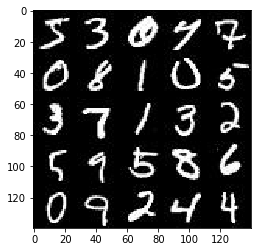

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

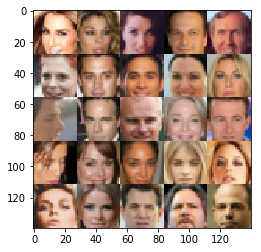

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [294]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Inspired by http://www.kdnuggets.com/2016/07/mnist-generative-adversarial-model-keras.html
    # I was initially going with deconv for generator, and that was producing many artefacts for celeb
    # However, deconv generator had much easier time learning mnist
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        depth_1, depth_2, depth_3 = 256, 512, 1024
        conv_k = 4
        keep_prob = 0.5
        
        # Input layer is 28x28xDEPTH
        x = tf.layers.conv2d(images, depth_1, conv_k, (2, 2), padding='same')
        x = tf.maximum(x * alpha, x)
        x = tf.nn.dropout(x, keep_prob=keep_prob)
        # now 14x14xdepth_1
        
        x = tf.layers.conv2d(x, depth_2, conv_k, (2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x * alpha, x)
        x = tf.nn.dropout(x, keep_prob=keep_prob)
        # now 7x7xdepth_2
        
        x = tf.layers.conv2d(x, depth_3, conv_k, (2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x * alpha, x)
        x = tf.nn.dropout(x, keep_prob=keep_prob)
        # now 4x4xdepth_3
        
        x = tf.reshape(x, (-1, 4*4*depth_3))
        
        logits = tf.layers.dense(x, 1)
        out = tf.nn.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [293]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=(not is_train)):
        alpha = 0.1
        depth_0, depth_1, depth_2 = 256, 128, 64
        conv_k = 3
        
        # leaky relu
        leaky_relu = lambda x: tf.maximum(x*alpha, x)
        
        # First fully connected layer
        x = tf.layers.dense(z, depth_0*14*14)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = leaky_relu(x)
        x = tf.reshape(x, (-1, 14, 14, depth_0)) # 7x7x512
        
        ups_1 = tf.image.resize_nearest_neighbor(x, (28, 28))
        conv_1 = tf.layers.conv2d(ups_1, depth_1, conv_k, strides=1, padding='same')
        conv_1 = tf.layers.batch_normalization(conv_1, training=is_train)
        conv_1 = leaky_relu(conv_1)
        
        conv_2 = tf.layers.conv2d(ups_1, depth_2, conv_k, strides=1, padding='same')
        conv_2 = tf.layers.batch_normalization(conv_2, training=is_train)
        conv_2 = leaky_relu(conv_2)
        
        # Output layer, 28x28xout_channel_dim
        logits = tf.layers.conv2d(conv_2, out_channel_dim, 1, strides=1, padding='same')
        
        out = tf.tanh(logits, name='generated_img')
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [265]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [87]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [247]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build the model
    input_real, input_z, tf_learning_rate = model_inputs(28, 28, data_shape[-1], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[-1])

    d_opt, g_opt = model_opt(d_loss, g_loss, tf_learning_rate, beta1)
    
    # Train the model
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, tf_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, tf_learning_rate: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}, step {}...".format(epoch_i+1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g),
                          "Total: {:.4f}".format(train_loss_d + train_loss_g)) 

                if steps % 100 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[-1], data_image_mode)

        tf.train.Saver().save(sess, './checkpoints/generator{}.ckpt'.format(data_image_mode))
        show_generator_output(sess, 9, input_z, data_shape[-1], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, step 10... Discriminator Loss: 0.8739... Generator Loss: 8.8113... Total: 9.6852
Epoch 1/2, step 20... Discriminator Loss: 1.0571... Generator Loss: 10.4676... Total: 11.5247
Epoch 1/2, step 30... Discriminator Loss: 0.4352... Generator Loss: 9.4904... Total: 9.9256
Epoch 1/2, step 40... Discriminator Loss: 1.1925... Generator Loss: 3.9427... Total: 5.1352
Epoch 1/2, step 50... Discriminator Loss: 3.5790... Generator Loss: 0.4416... Total: 4.0206
Epoch 1/2, step 60... Discriminator Loss: 5.6670... Generator Loss: 0.1169... Total: 5.7839
Epoch 1/2, step 70... Discriminator Loss: 3.4701... Generator Loss: 1.6030... Total: 5.0731
Epoch 1/2, step 80... Discriminator Loss: 2.1084... Generator Loss: 1.2909... Total: 3.3993
Epoch 1/2, step 90... Discriminator Loss: 2.8044... Generator Loss: 0.2909... Total: 3.0953
Epoch 1/2, step 100... Discriminator Loss: 1.1334... Generator Loss: 1.5496... Total: 2.6830


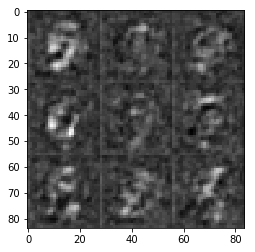

Epoch 1/2, step 110... Discriminator Loss: 1.9056... Generator Loss: 0.4995... Total: 2.4051
Epoch 1/2, step 120... Discriminator Loss: 0.9498... Generator Loss: 1.4786... Total: 2.4284
Epoch 1/2, step 130... Discriminator Loss: 1.4973... Generator Loss: 6.5594... Total: 8.0567
Epoch 1/2, step 140... Discriminator Loss: 0.4643... Generator Loss: 4.3965... Total: 4.8608
Epoch 1/2, step 150... Discriminator Loss: 0.6050... Generator Loss: 2.7346... Total: 3.3396
Epoch 1/2, step 160... Discriminator Loss: 0.5819... Generator Loss: 2.7307... Total: 3.3126
Epoch 1/2, step 170... Discriminator Loss: 0.4220... Generator Loss: 4.3560... Total: 4.7779
Epoch 1/2, step 180... Discriminator Loss: 0.3978... Generator Loss: 4.5948... Total: 4.9926
Epoch 1/2, step 190... Discriminator Loss: 0.4260... Generator Loss: 3.8613... Total: 4.2874
Epoch 1/2, step 200... Discriminator Loss: 0.4454... Generator Loss: 4.2127... Total: 4.6581


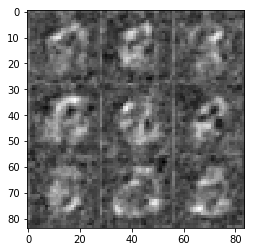

Epoch 1/2, step 210... Discriminator Loss: 2.1557... Generator Loss: 0.4253... Total: 2.5810
Epoch 1/2, step 220... Discriminator Loss: 1.4576... Generator Loss: 3.9743... Total: 5.4319
Epoch 1/2, step 230... Discriminator Loss: 2.6914... Generator Loss: 0.1522... Total: 2.8436
Epoch 1/2, step 240... Discriminator Loss: 2.4714... Generator Loss: 0.1792... Total: 2.6505
Epoch 1/2, step 250... Discriminator Loss: 1.1760... Generator Loss: 0.8233... Total: 1.9993
Epoch 1/2, step 260... Discriminator Loss: 1.3756... Generator Loss: 2.3896... Total: 3.7652
Epoch 1/2, step 270... Discriminator Loss: 1.4945... Generator Loss: 0.6791... Total: 2.1735
Epoch 1/2, step 280... Discriminator Loss: 1.1160... Generator Loss: 1.1092... Total: 2.2252
Epoch 1/2, step 290... Discriminator Loss: 0.8843... Generator Loss: 1.3062... Total: 2.1905
Epoch 1/2, step 300... Discriminator Loss: 0.9485... Generator Loss: 2.7697... Total: 3.7182


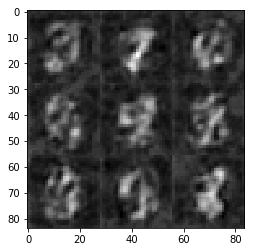

Epoch 1/2, step 310... Discriminator Loss: 0.8447... Generator Loss: 1.4354... Total: 2.2801
Epoch 1/2, step 320... Discriminator Loss: 0.7723... Generator Loss: 1.5170... Total: 2.2893
Epoch 1/2, step 330... Discriminator Loss: 1.0134... Generator Loss: 2.8522... Total: 3.8655
Epoch 1/2, step 340... Discriminator Loss: 0.7193... Generator Loss: 1.9159... Total: 2.6351
Epoch 1/2, step 350... Discriminator Loss: 0.7026... Generator Loss: 2.0390... Total: 2.7416
Epoch 1/2, step 360... Discriminator Loss: 1.0996... Generator Loss: 0.9717... Total: 2.0713
Epoch 1/2, step 370... Discriminator Loss: 0.9721... Generator Loss: 1.4635... Total: 2.4356
Epoch 1/2, step 380... Discriminator Loss: 0.8802... Generator Loss: 1.9463... Total: 2.8265
Epoch 1/2, step 390... Discriminator Loss: 0.8388... Generator Loss: 1.9364... Total: 2.7752
Epoch 1/2, step 400... Discriminator Loss: 1.0904... Generator Loss: 0.9497... Total: 2.0401


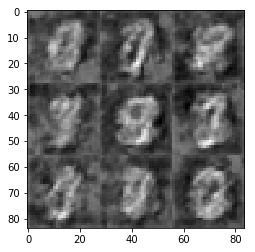

Epoch 1/2, step 410... Discriminator Loss: 0.9115... Generator Loss: 1.1732... Total: 2.0846
Epoch 1/2, step 420... Discriminator Loss: 1.3095... Generator Loss: 0.6329... Total: 1.9423
Epoch 1/2, step 430... Discriminator Loss: 1.7928... Generator Loss: 4.8115... Total: 6.6043
Epoch 1/2, step 440... Discriminator Loss: 1.1041... Generator Loss: 0.9453... Total: 2.0494
Epoch 1/2, step 450... Discriminator Loss: 0.7136... Generator Loss: 1.9035... Total: 2.6171
Epoch 1/2, step 460... Discriminator Loss: 1.2683... Generator Loss: 0.8195... Total: 2.0878
Epoch 1/2, step 470... Discriminator Loss: 0.8830... Generator Loss: 1.3825... Total: 2.2656
Epoch 1/2, step 480... Discriminator Loss: 1.5219... Generator Loss: 0.6441... Total: 2.1660
Epoch 1/2, step 490... Discriminator Loss: 0.8527... Generator Loss: 1.7311... Total: 2.5838
Epoch 1/2, step 500... Discriminator Loss: 0.8895... Generator Loss: 1.4862... Total: 2.3756


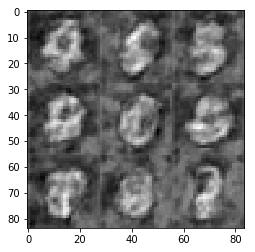

Epoch 1/2, step 510... Discriminator Loss: 1.7883... Generator Loss: 0.6239... Total: 2.4123
Epoch 1/2, step 520... Discriminator Loss: 1.1325... Generator Loss: 2.0441... Total: 3.1766
Epoch 1/2, step 530... Discriminator Loss: 0.9471... Generator Loss: 1.2879... Total: 2.2350
Epoch 1/2, step 540... Discriminator Loss: 0.5740... Generator Loss: 2.4146... Total: 2.9886
Epoch 1/2, step 550... Discriminator Loss: 0.6536... Generator Loss: 2.3913... Total: 3.0448
Epoch 1/2, step 560... Discriminator Loss: 1.0488... Generator Loss: 1.1462... Total: 2.1950
Epoch 1/2, step 570... Discriminator Loss: 1.7707... Generator Loss: 0.5826... Total: 2.3533
Epoch 1/2, step 580... Discriminator Loss: 0.8099... Generator Loss: 2.3681... Total: 3.1779
Epoch 1/2, step 590... Discriminator Loss: 0.6678... Generator Loss: 1.9490... Total: 2.6168
Epoch 1/2, step 600... Discriminator Loss: 0.6696... Generator Loss: 2.0899... Total: 2.7596


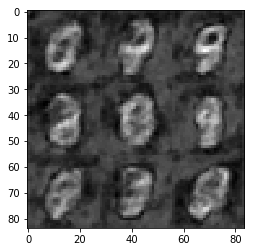

Epoch 1/2, step 610... Discriminator Loss: 0.6402... Generator Loss: 2.2025... Total: 2.8427
Epoch 1/2, step 620... Discriminator Loss: 0.6240... Generator Loss: 3.6405... Total: 4.2645
Epoch 1/2, step 630... Discriminator Loss: 1.4309... Generator Loss: 0.7065... Total: 2.1373
Epoch 1/2, step 640... Discriminator Loss: 0.9528... Generator Loss: 1.3540... Total: 2.3068
Epoch 1/2, step 650... Discriminator Loss: 1.2767... Generator Loss: 1.0052... Total: 2.2818
Epoch 1/2, step 660... Discriminator Loss: 0.6280... Generator Loss: 2.3750... Total: 3.0030
Epoch 1/2, step 670... Discriminator Loss: 0.6692... Generator Loss: 2.5495... Total: 3.2186
Epoch 1/2, step 680... Discriminator Loss: 0.5815... Generator Loss: 2.7063... Total: 3.2878
Epoch 1/2, step 690... Discriminator Loss: 2.8024... Generator Loss: 0.2791... Total: 3.0815
Epoch 1/2, step 700... Discriminator Loss: 0.8307... Generator Loss: 1.4804... Total: 2.3111


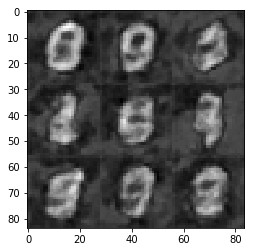

Epoch 1/2, step 710... Discriminator Loss: 0.8154... Generator Loss: 1.5636... Total: 2.3790
Epoch 1/2, step 720... Discriminator Loss: 0.7338... Generator Loss: 1.5744... Total: 2.3082
Epoch 1/2, step 730... Discriminator Loss: 0.5933... Generator Loss: 2.3145... Total: 2.9079
Epoch 1/2, step 740... Discriminator Loss: 0.5944... Generator Loss: 3.5364... Total: 4.1308
Epoch 1/2, step 750... Discriminator Loss: 0.5979... Generator Loss: 2.1427... Total: 2.7406
Epoch 1/2, step 760... Discriminator Loss: 0.5175... Generator Loss: 2.8426... Total: 3.3601
Epoch 1/2, step 770... Discriminator Loss: 0.8147... Generator Loss: 1.5910... Total: 2.4056
Epoch 1/2, step 780... Discriminator Loss: 1.4672... Generator Loss: 0.7094... Total: 2.1766
Epoch 1/2, step 790... Discriminator Loss: 0.8113... Generator Loss: 1.3718... Total: 2.1832
Epoch 1/2, step 800... Discriminator Loss: 0.8030... Generator Loss: 1.8159... Total: 2.6189


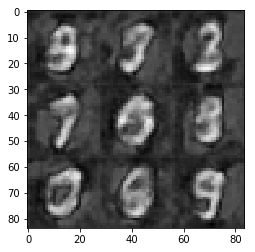

Epoch 1/2, step 810... Discriminator Loss: 0.5899... Generator Loss: 2.5247... Total: 3.1147
Epoch 1/2, step 820... Discriminator Loss: 0.5640... Generator Loss: 2.9160... Total: 3.4799
Epoch 1/2, step 830... Discriminator Loss: 0.5495... Generator Loss: 2.5822... Total: 3.1317
Epoch 1/2, step 840... Discriminator Loss: 0.5116... Generator Loss: 3.2688... Total: 3.7804
Epoch 1/2, step 850... Discriminator Loss: 0.4796... Generator Loss: 3.2692... Total: 3.7488
Epoch 1/2, step 860... Discriminator Loss: 2.3401... Generator Loss: 0.4160... Total: 2.7561
Epoch 1/2, step 870... Discriminator Loss: 0.8488... Generator Loss: 2.8957... Total: 3.7445
Epoch 1/2, step 880... Discriminator Loss: 0.9263... Generator Loss: 1.5581... Total: 2.4845
Epoch 1/2, step 890... Discriminator Loss: 0.5399... Generator Loss: 2.6173... Total: 3.1572
Epoch 1/2, step 900... Discriminator Loss: 0.5498... Generator Loss: 2.1487... Total: 2.6986


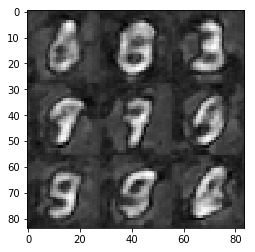

Epoch 1/2, step 910... Discriminator Loss: 0.4354... Generator Loss: 4.1653... Total: 4.6007
Epoch 1/2, step 920... Discriminator Loss: 0.4659... Generator Loss: 3.6852... Total: 4.1511
Epoch 1/2, step 930... Discriminator Loss: 0.5965... Generator Loss: 2.2364... Total: 2.8329
Epoch 2/2, step 940... Discriminator Loss: 0.5248... Generator Loss: 3.0395... Total: 3.5643
Epoch 2/2, step 950... Discriminator Loss: 0.4793... Generator Loss: 3.0726... Total: 3.5519
Epoch 2/2, step 960... Discriminator Loss: 0.4308... Generator Loss: 3.5692... Total: 3.9999
Epoch 2/2, step 970... Discriminator Loss: 0.4303... Generator Loss: 3.7627... Total: 4.1930
Epoch 2/2, step 980... Discriminator Loss: 0.8014... Generator Loss: 1.8838... Total: 2.6852
Epoch 2/2, step 990... Discriminator Loss: 0.7725... Generator Loss: 4.1252... Total: 4.8977
Epoch 2/2, step 1000... Discriminator Loss: 0.6079... Generator Loss: 2.4226... Total: 3.0306


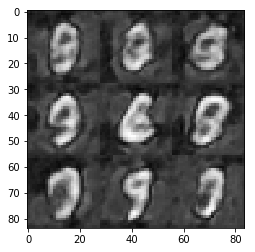

Epoch 2/2, step 1010... Discriminator Loss: 0.4628... Generator Loss: 3.1852... Total: 3.6480
Epoch 2/2, step 1020... Discriminator Loss: 0.4457... Generator Loss: 3.1849... Total: 3.6305
Epoch 2/2, step 1030... Discriminator Loss: 0.4757... Generator Loss: 2.8832... Total: 3.3589
Epoch 2/2, step 1040... Discriminator Loss: 0.6323... Generator Loss: 2.1076... Total: 2.7398
Epoch 2/2, step 1050... Discriminator Loss: 0.4220... Generator Loss: 3.9929... Total: 4.4149
Epoch 2/2, step 1060... Discriminator Loss: 0.3940... Generator Loss: 4.6071... Total: 5.0011
Epoch 2/2, step 1070... Discriminator Loss: 0.4199... Generator Loss: 4.4558... Total: 4.8757
Epoch 2/2, step 1080... Discriminator Loss: 0.3944... Generator Loss: 5.0732... Total: 5.4676
Epoch 2/2, step 1090... Discriminator Loss: 0.7646... Generator Loss: 1.9321... Total: 2.6967
Epoch 2/2, step 1100... Discriminator Loss: 2.7034... Generator Loss: 0.1719... Total: 2.8753


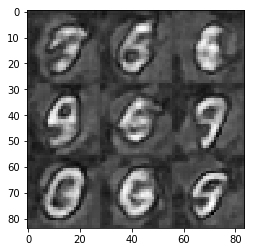

Epoch 2/2, step 1110... Discriminator Loss: 0.7109... Generator Loss: 3.4197... Total: 4.1306
Epoch 2/2, step 1120... Discriminator Loss: 0.8967... Generator Loss: 2.9570... Total: 3.8537
Epoch 2/2, step 1130... Discriminator Loss: 0.7363... Generator Loss: 1.6917... Total: 2.4280
Epoch 2/2, step 1140... Discriminator Loss: 0.6551... Generator Loss: 1.9088... Total: 2.5639
Epoch 2/2, step 1150... Discriminator Loss: 0.6949... Generator Loss: 1.6358... Total: 2.3307
Epoch 2/2, step 1160... Discriminator Loss: 0.5714... Generator Loss: 2.8817... Total: 3.4530
Epoch 2/2, step 1170... Discriminator Loss: 0.8418... Generator Loss: 1.5308... Total: 2.3726
Epoch 2/2, step 1180... Discriminator Loss: 1.4801... Generator Loss: 0.8375... Total: 2.3176
Epoch 2/2, step 1190... Discriminator Loss: 0.4836... Generator Loss: 2.7334... Total: 3.2171
Epoch 2/2, step 1200... Discriminator Loss: 0.4684... Generator Loss: 2.9552... Total: 3.4236


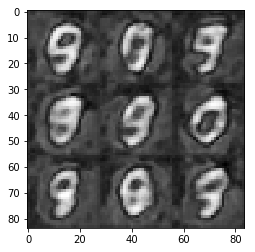

Epoch 2/2, step 1210... Discriminator Loss: 0.4733... Generator Loss: 3.0631... Total: 3.5364
Epoch 2/2, step 1220... Discriminator Loss: 0.4666... Generator Loss: 2.8810... Total: 3.3477
Epoch 2/2, step 1230... Discriminator Loss: 0.9191... Generator Loss: 1.6410... Total: 2.5601
Epoch 2/2, step 1240... Discriminator Loss: 0.8006... Generator Loss: 2.1061... Total: 2.9066
Epoch 2/2, step 1250... Discriminator Loss: 1.5668... Generator Loss: 5.3535... Total: 6.9203
Epoch 2/2, step 1260... Discriminator Loss: 0.7220... Generator Loss: 2.1395... Total: 2.8614
Epoch 2/2, step 1270... Discriminator Loss: 0.7324... Generator Loss: 1.9726... Total: 2.7050
Epoch 2/2, step 1280... Discriminator Loss: 0.7237... Generator Loss: 2.1472... Total: 2.8709
Epoch 2/2, step 1290... Discriminator Loss: 0.5056... Generator Loss: 3.0769... Total: 3.5825
Epoch 2/2, step 1300... Discriminator Loss: 0.5698... Generator Loss: 2.6395... Total: 3.2093


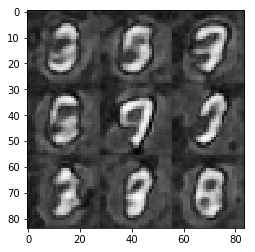

Epoch 2/2, step 1310... Discriminator Loss: 0.4683... Generator Loss: 3.6088... Total: 4.0771
Epoch 2/2, step 1320... Discriminator Loss: 0.8589... Generator Loss: 1.6636... Total: 2.5225
Epoch 2/2, step 1330... Discriminator Loss: 0.4630... Generator Loss: 3.3622... Total: 3.8252
Epoch 2/2, step 1340... Discriminator Loss: 0.5591... Generator Loss: 2.2338... Total: 2.7929
Epoch 2/2, step 1350... Discriminator Loss: 0.5429... Generator Loss: 3.3071... Total: 3.8500
Epoch 2/2, step 1360... Discriminator Loss: 0.4821... Generator Loss: 2.5680... Total: 3.0500
Epoch 2/2, step 1370... Discriminator Loss: 2.0765... Generator Loss: 0.3336... Total: 2.4101
Epoch 2/2, step 1380... Discriminator Loss: 0.9135... Generator Loss: 1.3710... Total: 2.2844
Epoch 2/2, step 1390... Discriminator Loss: 0.7230... Generator Loss: 2.1811... Total: 2.9040
Epoch 2/2, step 1400... Discriminator Loss: 1.3550... Generator Loss: 0.9543... Total: 2.3092


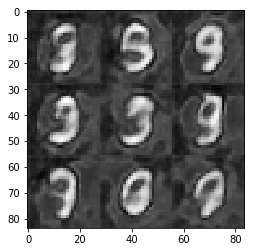

Epoch 2/2, step 1410... Discriminator Loss: 0.5763... Generator Loss: 2.5058... Total: 3.0822
Epoch 2/2, step 1420... Discriminator Loss: 0.6833... Generator Loss: 2.1953... Total: 2.8786
Epoch 2/2, step 1430... Discriminator Loss: 0.5573... Generator Loss: 2.6870... Total: 3.2443
Epoch 2/2, step 1440... Discriminator Loss: 0.5274... Generator Loss: 2.8126... Total: 3.3400
Epoch 2/2, step 1450... Discriminator Loss: 0.5778... Generator Loss: 2.8285... Total: 3.4063
Epoch 2/2, step 1460... Discriminator Loss: 0.7253... Generator Loss: 1.8496... Total: 2.5749
Epoch 2/2, step 1470... Discriminator Loss: 0.6313... Generator Loss: 2.0389... Total: 2.6702
Epoch 2/2, step 1480... Discriminator Loss: 0.4994... Generator Loss: 3.3969... Total: 3.8963
Epoch 2/2, step 1490... Discriminator Loss: 0.4730... Generator Loss: 3.9990... Total: 4.4721
Epoch 2/2, step 1500... Discriminator Loss: 0.4648... Generator Loss: 3.3173... Total: 3.7821


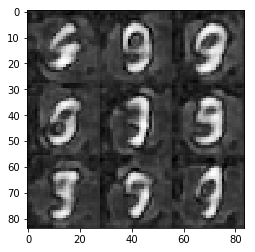

Epoch 2/2, step 1510... Discriminator Loss: 0.6240... Generator Loss: 2.1225... Total: 2.7465
Epoch 2/2, step 1520... Discriminator Loss: 0.4788... Generator Loss: 2.6783... Total: 3.1571
Epoch 2/2, step 1530... Discriminator Loss: 0.4233... Generator Loss: 3.7095... Total: 4.1328
Epoch 2/2, step 1540... Discriminator Loss: 0.5057... Generator Loss: 3.8649... Total: 4.3707
Epoch 2/2, step 1550... Discriminator Loss: 0.7300... Generator Loss: 1.8494... Total: 2.5794
Epoch 2/2, step 1560... Discriminator Loss: 0.5304... Generator Loss: 3.2595... Total: 3.7899
Epoch 2/2, step 1570... Discriminator Loss: 0.6366... Generator Loss: 2.0509... Total: 2.6875
Epoch 2/2, step 1580... Discriminator Loss: 0.5087... Generator Loss: 3.3221... Total: 3.8308
Epoch 2/2, step 1590... Discriminator Loss: 0.4952... Generator Loss: 2.3825... Total: 2.8776
Epoch 2/2, step 1600... Discriminator Loss: 2.2077... Generator Loss: 0.4657... Total: 2.6734


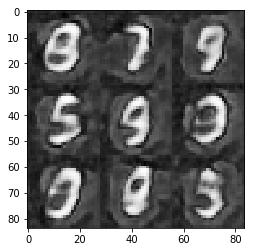

Epoch 2/2, step 1610... Discriminator Loss: 1.7176... Generator Loss: 0.4914... Total: 2.2090
Epoch 2/2, step 1620... Discriminator Loss: 0.7568... Generator Loss: 1.7083... Total: 2.4651
Epoch 2/2, step 1630... Discriminator Loss: 0.6171... Generator Loss: 3.1090... Total: 3.7260
Epoch 2/2, step 1640... Discriminator Loss: 0.9917... Generator Loss: 4.1088... Total: 5.1005
Epoch 2/2, step 1650... Discriminator Loss: 0.6786... Generator Loss: 1.8636... Total: 2.5422
Epoch 2/2, step 1660... Discriminator Loss: 0.5671... Generator Loss: 2.8637... Total: 3.4308
Epoch 2/2, step 1670... Discriminator Loss: 0.5052... Generator Loss: 2.8925... Total: 3.3977
Epoch 2/2, step 1680... Discriminator Loss: 0.4814... Generator Loss: 3.2977... Total: 3.7791
Epoch 2/2, step 1690... Discriminator Loss: 0.5120... Generator Loss: 5.0629... Total: 5.5749
Epoch 2/2, step 1700... Discriminator Loss: 0.5712... Generator Loss: 2.1286... Total: 2.6998


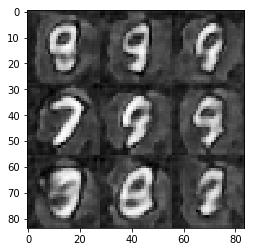

Epoch 2/2, step 1710... Discriminator Loss: 0.5349... Generator Loss: 2.7163... Total: 3.2512
Epoch 2/2, step 1720... Discriminator Loss: 0.5294... Generator Loss: 2.4687... Total: 2.9981
Epoch 2/2, step 1730... Discriminator Loss: 0.6310... Generator Loss: 2.3920... Total: 3.0230
Epoch 2/2, step 1740... Discriminator Loss: 0.4629... Generator Loss: 3.0462... Total: 3.5092
Epoch 2/2, step 1750... Discriminator Loss: 0.6988... Generator Loss: 4.3212... Total: 5.0200
Epoch 2/2, step 1760... Discriminator Loss: 0.4649... Generator Loss: 2.7465... Total: 3.2114
Epoch 2/2, step 1770... Discriminator Loss: 0.4224... Generator Loss: 3.7488... Total: 4.1712
Epoch 2/2, step 1780... Discriminator Loss: 0.4797... Generator Loss: 3.5937... Total: 4.0734
Epoch 2/2, step 1790... Discriminator Loss: 1.0899... Generator Loss: 2.0177... Total: 3.1075
Epoch 2/2, step 1800... Discriminator Loss: 1.3437... Generator Loss: 0.8672... Total: 2.2109


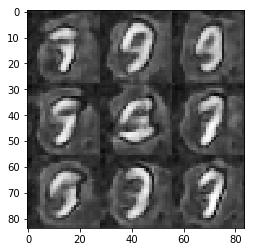

Epoch 2/2, step 1810... Discriminator Loss: 0.8833... Generator Loss: 3.1276... Total: 4.0109
Epoch 2/2, step 1820... Discriminator Loss: 0.7903... Generator Loss: 1.2521... Total: 2.0425
Epoch 2/2, step 1830... Discriminator Loss: 0.6339... Generator Loss: 1.7616... Total: 2.3955
Epoch 2/2, step 1840... Discriminator Loss: 0.5298... Generator Loss: 2.7133... Total: 3.2431
Epoch 2/2, step 1850... Discriminator Loss: 1.7323... Generator Loss: 4.7893... Total: 6.5216
Epoch 2/2, step 1860... Discriminator Loss: 0.6946... Generator Loss: 1.9358... Total: 2.6304
Epoch 2/2, step 1870... Discriminator Loss: 0.6479... Generator Loss: 2.0864... Total: 2.7342


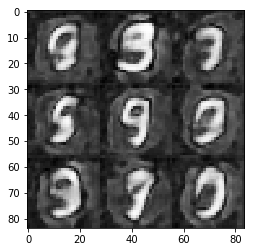

In [288]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, step 10... Discriminator Loss: 0.7629... Generator Loss: 7.1447... Total: 7.9075
Epoch 1/1, step 20... Discriminator Loss: 3.5004... Generator Loss: 0.9163... Total: 4.4166
Epoch 1/1, step 30... Discriminator Loss: 0.7066... Generator Loss: 5.2322... Total: 5.9388
Epoch 1/1, step 40... Discriminator Loss: 0.8015... Generator Loss: 3.9296... Total: 4.7311
Epoch 1/1, step 50... Discriminator Loss: 0.6914... Generator Loss: 2.4508... Total: 3.1422
Epoch 1/1, step 60... Discriminator Loss: 1.0171... Generator Loss: 2.0788... Total: 3.0959
Epoch 1/1, step 70... Discriminator Loss: 1.0261... Generator Loss: 1.9453... Total: 2.9714
Epoch 1/1, step 80... Discriminator Loss: 0.8745... Generator Loss: 4.4101... Total: 5.2846
Epoch 1/1, step 90... Discriminator Loss: 0.5899... Generator Loss: 3.0867... Total: 3.6766
Epoch 1/1, step 100... Discriminator Loss: 0.5097... Generator Loss: 5.2138... Total: 5.7235


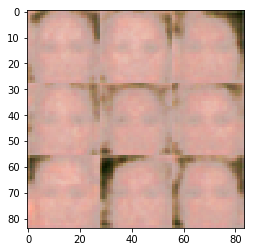

Epoch 1/1, step 110... Discriminator Loss: 0.5090... Generator Loss: 3.2009... Total: 3.7099
Epoch 1/1, step 120... Discriminator Loss: 0.7255... Generator Loss: 2.5349... Total: 3.2605
Epoch 1/1, step 130... Discriminator Loss: 1.6616... Generator Loss: 3.1330... Total: 4.7945
Epoch 1/1, step 140... Discriminator Loss: 2.9059... Generator Loss: 0.1996... Total: 3.1055
Epoch 1/1, step 150... Discriminator Loss: 1.8032... Generator Loss: 0.6758... Total: 2.4789
Epoch 1/1, step 160... Discriminator Loss: 0.9177... Generator Loss: 2.2432... Total: 3.1609
Epoch 1/1, step 170... Discriminator Loss: 1.6375... Generator Loss: 0.5485... Total: 2.1859
Epoch 1/1, step 180... Discriminator Loss: 1.6658... Generator Loss: 0.6613... Total: 2.3271
Epoch 1/1, step 190... Discriminator Loss: 1.6960... Generator Loss: 0.7709... Total: 2.4669
Epoch 1/1, step 200... Discriminator Loss: 1.4046... Generator Loss: 1.2975... Total: 2.7021


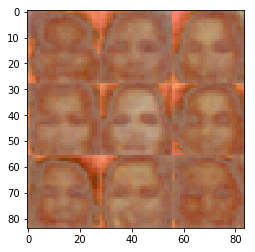

Epoch 1/1, step 210... Discriminator Loss: 1.4660... Generator Loss: 0.7718... Total: 2.2378
Epoch 1/1, step 220... Discriminator Loss: 1.8057... Generator Loss: 0.3744... Total: 2.1801
Epoch 1/1, step 230... Discriminator Loss: 1.9589... Generator Loss: 0.4290... Total: 2.3879
Epoch 1/1, step 240... Discriminator Loss: 1.5616... Generator Loss: 0.6850... Total: 2.2466
Epoch 1/1, step 250... Discriminator Loss: 1.3546... Generator Loss: 0.7529... Total: 2.1074
Epoch 1/1, step 260... Discriminator Loss: 1.3794... Generator Loss: 0.7875... Total: 2.1669
Epoch 1/1, step 270... Discriminator Loss: 1.6269... Generator Loss: 0.7531... Total: 2.3800
Epoch 1/1, step 280... Discriminator Loss: 1.1839... Generator Loss: 1.0402... Total: 2.2240
Epoch 1/1, step 290... Discriminator Loss: 1.6039... Generator Loss: 1.6060... Total: 3.2099
Epoch 1/1, step 300... Discriminator Loss: 1.1037... Generator Loss: 1.0483... Total: 2.1521


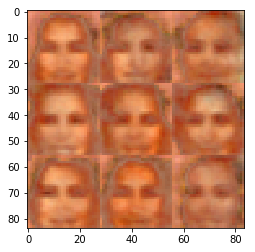

Epoch 1/1, step 310... Discriminator Loss: 1.3575... Generator Loss: 1.5310... Total: 2.8885
Epoch 1/1, step 320... Discriminator Loss: 1.3624... Generator Loss: 0.7296... Total: 2.0920
Epoch 1/1, step 330... Discriminator Loss: 2.9032... Generator Loss: 2.8934... Total: 5.7966
Epoch 1/1, step 340... Discriminator Loss: 1.3342... Generator Loss: 1.2492... Total: 2.5834
Epoch 1/1, step 350... Discriminator Loss: 1.5805... Generator Loss: 0.9470... Total: 2.5275
Epoch 1/1, step 360... Discriminator Loss: 1.8155... Generator Loss: 0.4782... Total: 2.2937
Epoch 1/1, step 370... Discriminator Loss: 1.5895... Generator Loss: 0.7146... Total: 2.3041
Epoch 1/1, step 380... Discriminator Loss: 1.3461... Generator Loss: 0.9584... Total: 2.3044
Epoch 1/1, step 390... Discriminator Loss: 1.8980... Generator Loss: 0.6827... Total: 2.5807
Epoch 1/1, step 400... Discriminator Loss: 1.4758... Generator Loss: 0.5943... Total: 2.0702


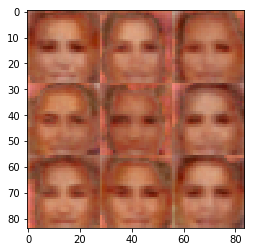

Epoch 1/1, step 410... Discriminator Loss: 1.6767... Generator Loss: 0.5693... Total: 2.2460
Epoch 1/1, step 420... Discriminator Loss: 1.2981... Generator Loss: 1.1059... Total: 2.4040
Epoch 1/1, step 430... Discriminator Loss: 1.1860... Generator Loss: 1.1680... Total: 2.3540
Epoch 1/1, step 440... Discriminator Loss: 1.8442... Generator Loss: 0.5981... Total: 2.4423
Epoch 1/1, step 450... Discriminator Loss: 1.1051... Generator Loss: 1.2484... Total: 2.3535
Epoch 1/1, step 460... Discriminator Loss: 1.5848... Generator Loss: 0.4623... Total: 2.0471
Epoch 1/1, step 470... Discriminator Loss: 1.4849... Generator Loss: 0.7532... Total: 2.2380
Epoch 1/1, step 480... Discriminator Loss: 1.7228... Generator Loss: 0.6778... Total: 2.4007
Epoch 1/1, step 490... Discriminator Loss: 1.3945... Generator Loss: 0.5034... Total: 1.8978
Epoch 1/1, step 500... Discriminator Loss: 1.1257... Generator Loss: 1.4294... Total: 2.5551


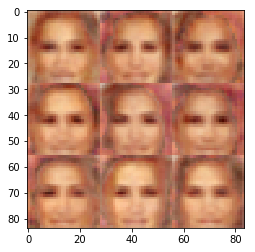

Epoch 1/1, step 510... Discriminator Loss: 1.2641... Generator Loss: 0.8308... Total: 2.0949
Epoch 1/1, step 520... Discriminator Loss: 1.2643... Generator Loss: 1.6107... Total: 2.8751
Epoch 1/1, step 530... Discriminator Loss: 1.6496... Generator Loss: 0.7904... Total: 2.4400
Epoch 1/1, step 540... Discriminator Loss: 1.2833... Generator Loss: 0.6444... Total: 1.9277
Epoch 1/1, step 550... Discriminator Loss: 1.3914... Generator Loss: 1.5163... Total: 2.9077
Epoch 1/1, step 560... Discriminator Loss: 1.5948... Generator Loss: 0.9743... Total: 2.5691
Epoch 1/1, step 570... Discriminator Loss: 1.2746... Generator Loss: 0.8615... Total: 2.1361
Epoch 1/1, step 580... Discriminator Loss: 1.3397... Generator Loss: 1.5447... Total: 2.8844
Epoch 1/1, step 590... Discriminator Loss: 1.9966... Generator Loss: 0.3156... Total: 2.3122
Epoch 1/1, step 600... Discriminator Loss: 1.5999... Generator Loss: 2.2110... Total: 3.8109


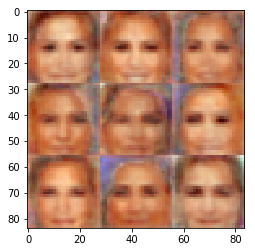

Epoch 1/1, step 610... Discriminator Loss: 2.2761... Generator Loss: 2.6491... Total: 4.9252
Epoch 1/1, step 620... Discriminator Loss: 1.2240... Generator Loss: 1.0653... Total: 2.2893
Epoch 1/1, step 630... Discriminator Loss: 1.2304... Generator Loss: 0.6669... Total: 1.8972
Epoch 1/1, step 640... Discriminator Loss: 1.6217... Generator Loss: 0.4538... Total: 2.0756
Epoch 1/1, step 650... Discriminator Loss: 1.4738... Generator Loss: 0.7563... Total: 2.2300
Epoch 1/1, step 660... Discriminator Loss: 1.7178... Generator Loss: 0.3971... Total: 2.1149
Epoch 1/1, step 670... Discriminator Loss: 1.5382... Generator Loss: 0.6188... Total: 2.1570
Epoch 1/1, step 680... Discriminator Loss: 1.4375... Generator Loss: 1.9310... Total: 3.3685
Epoch 1/1, step 690... Discriminator Loss: 1.6754... Generator Loss: 0.4292... Total: 2.1046
Epoch 1/1, step 700... Discriminator Loss: 1.4306... Generator Loss: 0.6761... Total: 2.1067


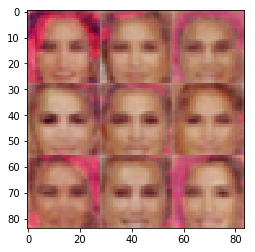

Epoch 1/1, step 710... Discriminator Loss: 1.6012... Generator Loss: 0.9582... Total: 2.5595
Epoch 1/1, step 720... Discriminator Loss: 1.4078... Generator Loss: 0.6194... Total: 2.0271
Epoch 1/1, step 730... Discriminator Loss: 1.3548... Generator Loss: 0.6805... Total: 2.0353
Epoch 1/1, step 740... Discriminator Loss: 2.3785... Generator Loss: 0.2188... Total: 2.5973
Epoch 1/1, step 750... Discriminator Loss: 1.2269... Generator Loss: 1.0734... Total: 2.3003
Epoch 1/1, step 760... Discriminator Loss: 1.5174... Generator Loss: 0.4937... Total: 2.0110
Epoch 1/1, step 770... Discriminator Loss: 1.4161... Generator Loss: 0.8193... Total: 2.2354
Epoch 1/1, step 780... Discriminator Loss: 1.5139... Generator Loss: 0.5414... Total: 2.0553
Epoch 1/1, step 790... Discriminator Loss: 1.1376... Generator Loss: 1.6606... Total: 2.7981
Epoch 1/1, step 800... Discriminator Loss: 1.4649... Generator Loss: 2.9576... Total: 4.4226


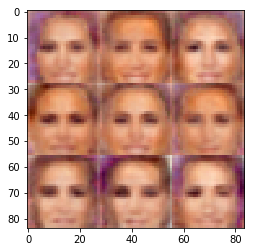

Epoch 1/1, step 810... Discriminator Loss: 1.3595... Generator Loss: 0.7141... Total: 2.0736
Epoch 1/1, step 820... Discriminator Loss: 1.4508... Generator Loss: 0.5549... Total: 2.0057
Epoch 1/1, step 830... Discriminator Loss: 1.5091... Generator Loss: 1.6910... Total: 3.2002
Epoch 1/1, step 840... Discriminator Loss: 1.0923... Generator Loss: 0.8291... Total: 1.9214
Epoch 1/1, step 850... Discriminator Loss: 1.1666... Generator Loss: 0.7530... Total: 1.9196
Epoch 1/1, step 860... Discriminator Loss: 1.2066... Generator Loss: 1.1144... Total: 2.3210
Epoch 1/1, step 870... Discriminator Loss: 2.1514... Generator Loss: 0.2566... Total: 2.4080
Epoch 1/1, step 880... Discriminator Loss: 1.4410... Generator Loss: 0.7477... Total: 2.1888
Epoch 1/1, step 890... Discriminator Loss: 1.7771... Generator Loss: 0.8076... Total: 2.5847
Epoch 1/1, step 900... Discriminator Loss: 0.9619... Generator Loss: 0.9922... Total: 1.9541


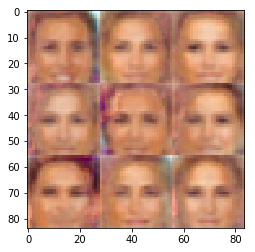

Epoch 1/1, step 910... Discriminator Loss: 1.1792... Generator Loss: 0.7537... Total: 1.9330
Epoch 1/1, step 920... Discriminator Loss: 1.9248... Generator Loss: 1.5270... Total: 3.4518
Epoch 1/1, step 930... Discriminator Loss: 1.4999... Generator Loss: 0.6007... Total: 2.1006
Epoch 1/1, step 940... Discriminator Loss: 1.0333... Generator Loss: 1.4229... Total: 2.4562
Epoch 1/1, step 950... Discriminator Loss: 0.8343... Generator Loss: 1.8716... Total: 2.7059
Epoch 1/1, step 960... Discriminator Loss: 1.5820... Generator Loss: 0.4684... Total: 2.0504
Epoch 1/1, step 970... Discriminator Loss: 1.3698... Generator Loss: 0.7663... Total: 2.1360
Epoch 1/1, step 980... Discriminator Loss: 0.9953... Generator Loss: 0.8686... Total: 1.8639
Epoch 1/1, step 990... Discriminator Loss: 1.2338... Generator Loss: 1.4459... Total: 2.6797
Epoch 1/1, step 1000... Discriminator Loss: 1.4827... Generator Loss: 1.7995... Total: 3.2822


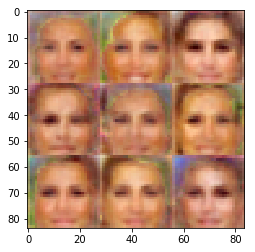

Epoch 1/1, step 1010... Discriminator Loss: 1.3737... Generator Loss: 0.8587... Total: 2.2324
Epoch 1/1, step 1020... Discriminator Loss: 0.9258... Generator Loss: 1.0391... Total: 1.9648
Epoch 1/1, step 1030... Discriminator Loss: 1.1992... Generator Loss: 1.0188... Total: 2.2180
Epoch 1/1, step 1040... Discriminator Loss: 1.9254... Generator Loss: 0.4332... Total: 2.3586
Epoch 1/1, step 1050... Discriminator Loss: 1.6159... Generator Loss: 0.7571... Total: 2.3730
Epoch 1/1, step 1060... Discriminator Loss: 1.2220... Generator Loss: 0.8437... Total: 2.0658
Epoch 1/1, step 1070... Discriminator Loss: 1.1743... Generator Loss: 0.8229... Total: 1.9972
Epoch 1/1, step 1080... Discriminator Loss: 2.0305... Generator Loss: 0.5795... Total: 2.6100
Epoch 1/1, step 1090... Discriminator Loss: 1.8947... Generator Loss: 0.3481... Total: 2.2428
Epoch 1/1, step 1100... Discriminator Loss: 1.6960... Generator Loss: 0.6857... Total: 2.3817


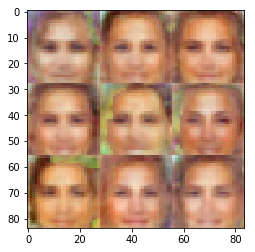

Epoch 1/1, step 1110... Discriminator Loss: 0.8618... Generator Loss: 1.1661... Total: 2.0279
Epoch 1/1, step 1120... Discriminator Loss: 0.7799... Generator Loss: 1.4019... Total: 2.1817
Epoch 1/1, step 1130... Discriminator Loss: 0.4675... Generator Loss: 2.6544... Total: 3.1218
Epoch 1/1, step 1140... Discriminator Loss: 0.9538... Generator Loss: 1.7245... Total: 2.6783
Epoch 1/1, step 1150... Discriminator Loss: 1.1184... Generator Loss: 1.1260... Total: 2.2444
Epoch 1/1, step 1160... Discriminator Loss: 1.6605... Generator Loss: 0.4992... Total: 2.1596
Epoch 1/1, step 1170... Discriminator Loss: 0.9956... Generator Loss: 1.3726... Total: 2.3683
Epoch 1/1, step 1180... Discriminator Loss: 1.0172... Generator Loss: 1.0695... Total: 2.0868
Epoch 1/1, step 1190... Discriminator Loss: 1.1986... Generator Loss: 0.6711... Total: 1.8697
Epoch 1/1, step 1200... Discriminator Loss: 0.8350... Generator Loss: 1.6733... Total: 2.5083


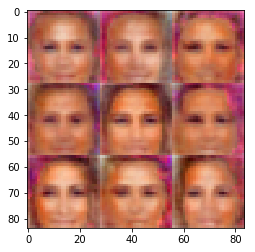

Epoch 1/1, step 1210... Discriminator Loss: 1.0740... Generator Loss: 1.9916... Total: 3.0656
Epoch 1/1, step 1220... Discriminator Loss: 1.1953... Generator Loss: 2.5157... Total: 3.7111
Epoch 1/1, step 1230... Discriminator Loss: 1.3038... Generator Loss: 0.8579... Total: 2.1618
Epoch 1/1, step 1240... Discriminator Loss: 1.6942... Generator Loss: 0.6203... Total: 2.3145
Epoch 1/1, step 1250... Discriminator Loss: 1.6445... Generator Loss: 1.5946... Total: 3.2391
Epoch 1/1, step 1260... Discriminator Loss: 1.1949... Generator Loss: 1.1259... Total: 2.3208
Epoch 1/1, step 1270... Discriminator Loss: 0.9561... Generator Loss: 1.0523... Total: 2.0084
Epoch 1/1, step 1280... Discriminator Loss: 0.9770... Generator Loss: 1.2021... Total: 2.1791
Epoch 1/1, step 1290... Discriminator Loss: 1.4614... Generator Loss: 0.5625... Total: 2.0239
Epoch 1/1, step 1300... Discriminator Loss: 0.7202... Generator Loss: 1.4080... Total: 2.1281


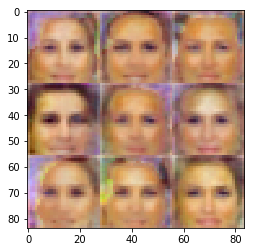

Epoch 1/1, step 1310... Discriminator Loss: 1.4640... Generator Loss: 0.5612... Total: 2.0252
Epoch 1/1, step 1320... Discriminator Loss: 1.7981... Generator Loss: 0.4307... Total: 2.2288
Epoch 1/1, step 1330... Discriminator Loss: 0.9130... Generator Loss: 1.0622... Total: 1.9752
Epoch 1/1, step 1340... Discriminator Loss: 1.0705... Generator Loss: 1.0155... Total: 2.0860
Epoch 1/1, step 1350... Discriminator Loss: 0.7271... Generator Loss: 1.9511... Total: 2.6782
Epoch 1/1, step 1360... Discriminator Loss: 1.3218... Generator Loss: 0.8737... Total: 2.1955
Epoch 1/1, step 1370... Discriminator Loss: 0.6731... Generator Loss: 2.1202... Total: 2.7933
Epoch 1/1, step 1380... Discriminator Loss: 0.9374... Generator Loss: 1.3288... Total: 2.2662
Epoch 1/1, step 1390... Discriminator Loss: 1.7068... Generator Loss: 0.5270... Total: 2.2338
Epoch 1/1, step 1400... Discriminator Loss: 1.4993... Generator Loss: 0.6719... Total: 2.1711


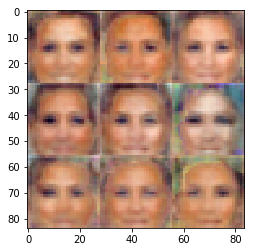

Epoch 1/1, step 1410... Discriminator Loss: 1.3154... Generator Loss: 0.9237... Total: 2.2391
Epoch 1/1, step 1420... Discriminator Loss: 1.5166... Generator Loss: 0.5679... Total: 2.0845
Epoch 1/1, step 1430... Discriminator Loss: 1.0912... Generator Loss: 1.8079... Total: 2.8991
Epoch 1/1, step 1440... Discriminator Loss: 1.1633... Generator Loss: 1.0208... Total: 2.1842
Epoch 1/1, step 1450... Discriminator Loss: 2.2577... Generator Loss: 0.2655... Total: 2.5232
Epoch 1/1, step 1460... Discriminator Loss: 1.4859... Generator Loss: 2.3688... Total: 3.8547
Epoch 1/1, step 1470... Discriminator Loss: 1.2272... Generator Loss: 0.9369... Total: 2.1641
Epoch 1/1, step 1480... Discriminator Loss: 1.4556... Generator Loss: 0.5958... Total: 2.0514
Epoch 1/1, step 1490... Discriminator Loss: 0.7860... Generator Loss: 2.7308... Total: 3.5169
Epoch 1/1, step 1500... Discriminator Loss: 1.3321... Generator Loss: 0.8845... Total: 2.2166


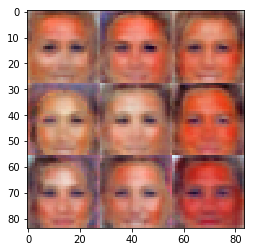

Epoch 1/1, step 1510... Discriminator Loss: 1.6197... Generator Loss: 0.5605... Total: 2.1802
Epoch 1/1, step 1520... Discriminator Loss: 1.2485... Generator Loss: 1.0565... Total: 2.3049
Epoch 1/1, step 1530... Discriminator Loss: 0.8981... Generator Loss: 1.1057... Total: 2.0038
Epoch 1/1, step 1540... Discriminator Loss: 0.7936... Generator Loss: 1.2764... Total: 2.0701
Epoch 1/1, step 1550... Discriminator Loss: 0.9583... Generator Loss: 1.0552... Total: 2.0136
Epoch 1/1, step 1560... Discriminator Loss: 1.3709... Generator Loss: 0.9205... Total: 2.2915
Epoch 1/1, step 1570... Discriminator Loss: 1.1339... Generator Loss: 1.1775... Total: 2.3114
Epoch 1/1, step 1580... Discriminator Loss: 1.4605... Generator Loss: 0.8158... Total: 2.2762
Epoch 1/1, step 1590... Discriminator Loss: 1.0318... Generator Loss: 1.4940... Total: 2.5257
Epoch 1/1, step 1600... Discriminator Loss: 1.4167... Generator Loss: 0.6760... Total: 2.0927


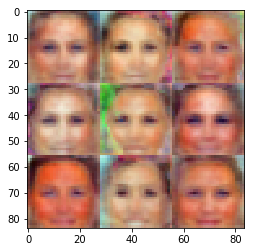

Epoch 1/1, step 1610... Discriminator Loss: 1.9265... Generator Loss: 0.3669... Total: 2.2934
Epoch 1/1, step 1620... Discriminator Loss: 1.7359... Generator Loss: 0.4328... Total: 2.1686
Epoch 1/1, step 1630... Discriminator Loss: 1.5988... Generator Loss: 0.6091... Total: 2.2079
Epoch 1/1, step 1640... Discriminator Loss: 1.5469... Generator Loss: 1.0295... Total: 2.5764
Epoch 1/1, step 1650... Discriminator Loss: 1.8112... Generator Loss: 2.7835... Total: 4.5948
Epoch 1/1, step 1660... Discriminator Loss: 1.2786... Generator Loss: 0.6313... Total: 1.9100
Epoch 1/1, step 1670... Discriminator Loss: 1.6711... Generator Loss: 0.3696... Total: 2.0407
Epoch 1/1, step 1680... Discriminator Loss: 1.3304... Generator Loss: 0.6903... Total: 2.0208
Epoch 1/1, step 1690... Discriminator Loss: 1.5398... Generator Loss: 0.6041... Total: 2.1439
Epoch 1/1, step 1700... Discriminator Loss: 1.2151... Generator Loss: 0.9593... Total: 2.1744


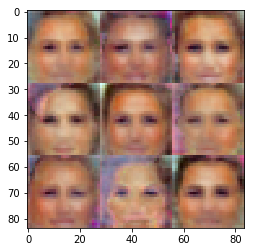

Epoch 1/1, step 1710... Discriminator Loss: 1.3216... Generator Loss: 0.6698... Total: 1.9914
Epoch 1/1, step 1720... Discriminator Loss: 1.7529... Generator Loss: 0.4736... Total: 2.2265
Epoch 1/1, step 1730... Discriminator Loss: 2.3109... Generator Loss: 1.3526... Total: 3.6636
Epoch 1/1, step 1740... Discriminator Loss: 0.7619... Generator Loss: 1.7084... Total: 2.4703
Epoch 1/1, step 1750... Discriminator Loss: 1.0024... Generator Loss: 1.3414... Total: 2.3437
Epoch 1/1, step 1760... Discriminator Loss: 1.8210... Generator Loss: 0.5357... Total: 2.3568
Epoch 1/1, step 1770... Discriminator Loss: 1.2787... Generator Loss: 0.7146... Total: 1.9933
Epoch 1/1, step 1780... Discriminator Loss: 1.7489... Generator Loss: 0.9923... Total: 2.7413
Epoch 1/1, step 1790... Discriminator Loss: 0.6915... Generator Loss: 2.0658... Total: 2.7573
Epoch 1/1, step 1800... Discriminator Loss: 1.8795... Generator Loss: 0.3918... Total: 2.2713


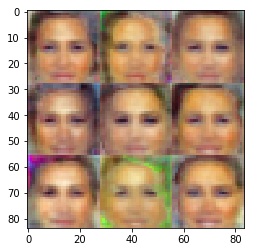

Epoch 1/1, step 1810... Discriminator Loss: 1.2763... Generator Loss: 1.1098... Total: 2.3861
Epoch 1/1, step 1820... Discriminator Loss: 1.5308... Generator Loss: 0.4633... Total: 1.9941
Epoch 1/1, step 1830... Discriminator Loss: 1.3586... Generator Loss: 0.9193... Total: 2.2779
Epoch 1/1, step 1840... Discriminator Loss: 1.3110... Generator Loss: 0.9049... Total: 2.2159
Epoch 1/1, step 1850... Discriminator Loss: 1.4343... Generator Loss: 0.7818... Total: 2.2161
Epoch 1/1, step 1860... Discriminator Loss: 1.4058... Generator Loss: 1.0608... Total: 2.4666
Epoch 1/1, step 1870... Discriminator Loss: 1.2894... Generator Loss: 0.9059... Total: 2.1952
Epoch 1/1, step 1880... Discriminator Loss: 1.6567... Generator Loss: 1.4210... Total: 3.0777
Epoch 1/1, step 1890... Discriminator Loss: 1.3895... Generator Loss: 1.1639... Total: 2.5534
Epoch 1/1, step 1900... Discriminator Loss: 1.0411... Generator Loss: 1.0750... Total: 2.1161


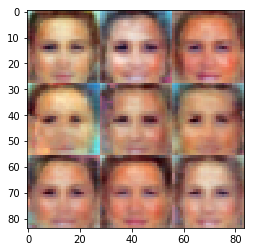

Epoch 1/1, step 1910... Discriminator Loss: 1.5611... Generator Loss: 0.5853... Total: 2.1464
Epoch 1/1, step 1920... Discriminator Loss: 1.2995... Generator Loss: 0.7098... Total: 2.0092
Epoch 1/1, step 1930... Discriminator Loss: 1.5694... Generator Loss: 0.6681... Total: 2.2374
Epoch 1/1, step 1940... Discriminator Loss: 1.2123... Generator Loss: 0.8468... Total: 2.0591
Epoch 1/1, step 1950... Discriminator Loss: 1.3262... Generator Loss: 1.2536... Total: 2.5798
Epoch 1/1, step 1960... Discriminator Loss: 1.7870... Generator Loss: 0.6499... Total: 2.4369
Epoch 1/1, step 1970... Discriminator Loss: 1.3246... Generator Loss: 0.6905... Total: 2.0151
Epoch 1/1, step 1980... Discriminator Loss: 1.1352... Generator Loss: 0.7766... Total: 1.9118
Epoch 1/1, step 1990... Discriminator Loss: 1.0396... Generator Loss: 1.1478... Total: 2.1874
Epoch 1/1, step 2000... Discriminator Loss: 1.3331... Generator Loss: 0.8739... Total: 2.2070


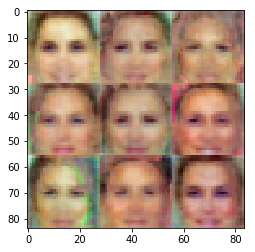

Epoch 1/1, step 2010... Discriminator Loss: 1.7793... Generator Loss: 0.4585... Total: 2.2378
Epoch 1/1, step 2020... Discriminator Loss: 1.8014... Generator Loss: 0.5740... Total: 2.3754
Epoch 1/1, step 2030... Discriminator Loss: 1.1113... Generator Loss: 0.8763... Total: 1.9876
Epoch 1/1, step 2040... Discriminator Loss: 1.5014... Generator Loss: 0.9981... Total: 2.4995
Epoch 1/1, step 2050... Discriminator Loss: 2.3412... Generator Loss: 0.3473... Total: 2.6885
Epoch 1/1, step 2060... Discriminator Loss: 0.8847... Generator Loss: 1.3750... Total: 2.2596
Epoch 1/1, step 2070... Discriminator Loss: 2.1436... Generator Loss: 0.2357... Total: 2.3792
Epoch 1/1, step 2080... Discriminator Loss: 1.7655... Generator Loss: 1.0208... Total: 2.7864
Epoch 1/1, step 2090... Discriminator Loss: 1.0926... Generator Loss: 0.9774... Total: 2.0700
Epoch 1/1, step 2100... Discriminator Loss: 1.2547... Generator Loss: 1.0984... Total: 2.3531


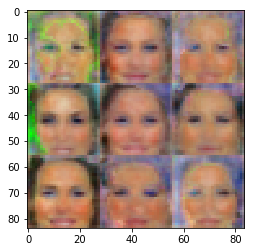

Epoch 1/1, step 2110... Discriminator Loss: 1.3719... Generator Loss: 0.6681... Total: 2.0400
Epoch 1/1, step 2120... Discriminator Loss: 1.2082... Generator Loss: 0.9877... Total: 2.1959
Epoch 1/1, step 2130... Discriminator Loss: 1.2993... Generator Loss: 0.7698... Total: 2.0691
Epoch 1/1, step 2140... Discriminator Loss: 1.3532... Generator Loss: 0.7527... Total: 2.1059
Epoch 1/1, step 2150... Discriminator Loss: 1.9009... Generator Loss: 0.4655... Total: 2.3664
Epoch 1/1, step 2160... Discriminator Loss: 1.7979... Generator Loss: 0.4572... Total: 2.2551
Epoch 1/1, step 2170... Discriminator Loss: 1.1469... Generator Loss: 0.9059... Total: 2.0529
Epoch 1/1, step 2180... Discriminator Loss: 1.2965... Generator Loss: 0.8132... Total: 2.1098
Epoch 1/1, step 2190... Discriminator Loss: 1.6662... Generator Loss: 0.8956... Total: 2.5618
Epoch 1/1, step 2200... Discriminator Loss: 1.3822... Generator Loss: 0.7002... Total: 2.0824


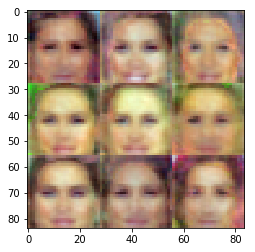

Epoch 1/1, step 2210... Discriminator Loss: 1.1629... Generator Loss: 0.9980... Total: 2.1609
Epoch 1/1, step 2220... Discriminator Loss: 1.1412... Generator Loss: 1.5132... Total: 2.6544
Epoch 1/1, step 2230... Discriminator Loss: 1.8061... Generator Loss: 0.6019... Total: 2.4081
Epoch 1/1, step 2240... Discriminator Loss: 1.1708... Generator Loss: 1.1856... Total: 2.3565
Epoch 1/1, step 2250... Discriminator Loss: 0.9699... Generator Loss: 1.1118... Total: 2.0817
Epoch 1/1, step 2260... Discriminator Loss: 1.3066... Generator Loss: 0.6360... Total: 1.9426
Epoch 1/1, step 2270... Discriminator Loss: 1.4055... Generator Loss: 1.5334... Total: 2.9389
Epoch 1/1, step 2280... Discriminator Loss: 1.5569... Generator Loss: 0.5774... Total: 2.1342
Epoch 1/1, step 2290... Discriminator Loss: 0.9739... Generator Loss: 1.2824... Total: 2.2563
Epoch 1/1, step 2300... Discriminator Loss: 1.2457... Generator Loss: 0.6558... Total: 1.9015


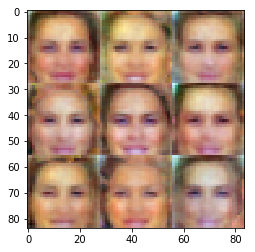

Epoch 1/1, step 2310... Discriminator Loss: 1.3343... Generator Loss: 1.4478... Total: 2.7821
Epoch 1/1, step 2320... Discriminator Loss: 1.5965... Generator Loss: 0.4888... Total: 2.0854
Epoch 1/1, step 2330... Discriminator Loss: 0.9061... Generator Loss: 1.2442... Total: 2.1503
Epoch 1/1, step 2340... Discriminator Loss: 1.6642... Generator Loss: 1.2804... Total: 2.9445
Epoch 1/1, step 2350... Discriminator Loss: 0.8460... Generator Loss: 1.4663... Total: 2.3123
Epoch 1/1, step 2360... Discriminator Loss: 1.6887... Generator Loss: 0.4874... Total: 2.1761
Epoch 1/1, step 2370... Discriminator Loss: 0.9724... Generator Loss: 2.4710... Total: 3.4435
Epoch 1/1, step 2380... Discriminator Loss: 0.7529... Generator Loss: 1.9392... Total: 2.6921
Epoch 1/1, step 2390... Discriminator Loss: 1.1778... Generator Loss: 0.8024... Total: 1.9802
Epoch 1/1, step 2400... Discriminator Loss: 1.1779... Generator Loss: 1.3099... Total: 2.4878


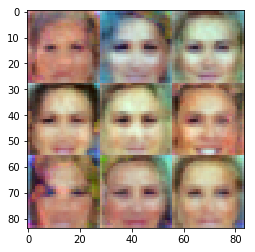

Epoch 1/1, step 2410... Discriminator Loss: 0.9860... Generator Loss: 1.3102... Total: 2.2962
Epoch 1/1, step 2420... Discriminator Loss: 1.2170... Generator Loss: 0.7189... Total: 1.9359
Epoch 1/1, step 2430... Discriminator Loss: 0.7710... Generator Loss: 2.8232... Total: 3.5942
Epoch 1/1, step 2440... Discriminator Loss: 1.2019... Generator Loss: 0.8671... Total: 2.0690
Epoch 1/1, step 2450... Discriminator Loss: 1.1829... Generator Loss: 0.8354... Total: 2.0183
Epoch 1/1, step 2460... Discriminator Loss: 1.2095... Generator Loss: 1.0817... Total: 2.2912
Epoch 1/1, step 2470... Discriminator Loss: 1.2580... Generator Loss: 0.7974... Total: 2.0553
Epoch 1/1, step 2480... Discriminator Loss: 1.2877... Generator Loss: 1.2360... Total: 2.5237
Epoch 1/1, step 2490... Discriminator Loss: 1.4494... Generator Loss: 1.2165... Total: 2.6659
Epoch 1/1, step 2500... Discriminator Loss: 1.3036... Generator Loss: 1.4232... Total: 2.7268


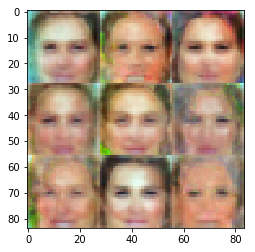

Epoch 1/1, step 2510... Discriminator Loss: 1.1504... Generator Loss: 1.2275... Total: 2.3779
Epoch 1/1, step 2520... Discriminator Loss: 1.1090... Generator Loss: 1.2265... Total: 2.3355
Epoch 1/1, step 2530... Discriminator Loss: 1.4809... Generator Loss: 0.5549... Total: 2.0358
Epoch 1/1, step 2540... Discriminator Loss: 1.1134... Generator Loss: 1.0462... Total: 2.1596
Epoch 1/1, step 2550... Discriminator Loss: 1.9252... Generator Loss: 0.4474... Total: 2.3726
Epoch 1/1, step 2560... Discriminator Loss: 1.5089... Generator Loss: 1.8923... Total: 3.4012
Epoch 1/1, step 2570... Discriminator Loss: 1.0382... Generator Loss: 1.2884... Total: 2.3266
Epoch 1/1, step 2580... Discriminator Loss: 1.2449... Generator Loss: 0.9636... Total: 2.2085
Epoch 1/1, step 2590... Discriminator Loss: 1.4087... Generator Loss: 0.5821... Total: 1.9908
Epoch 1/1, step 2600... Discriminator Loss: 2.9931... Generator Loss: 0.1315... Total: 3.1246


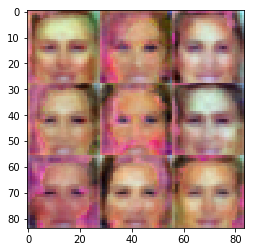

Epoch 1/1, step 2610... Discriminator Loss: 1.3834... Generator Loss: 1.6183... Total: 3.0017
Epoch 1/1, step 2620... Discriminator Loss: 1.6023... Generator Loss: 1.2233... Total: 2.8257
Epoch 1/1, step 2630... Discriminator Loss: 0.9660... Generator Loss: 1.4952... Total: 2.4612
Epoch 1/1, step 2640... Discriminator Loss: 2.1164... Generator Loss: 0.2952... Total: 2.4116
Epoch 1/1, step 2650... Discriminator Loss: 1.1208... Generator Loss: 2.8281... Total: 3.9489
Epoch 1/1, step 2660... Discriminator Loss: 1.2238... Generator Loss: 1.0205... Total: 2.2443
Epoch 1/1, step 2670... Discriminator Loss: 1.4497... Generator Loss: 0.6117... Total: 2.0614
Epoch 1/1, step 2680... Discriminator Loss: 0.8719... Generator Loss: 1.7191... Total: 2.5910
Epoch 1/1, step 2690... Discriminator Loss: 1.3791... Generator Loss: 0.7934... Total: 2.1725
Epoch 1/1, step 2700... Discriminator Loss: 1.9043... Generator Loss: 0.4417... Total: 2.3460


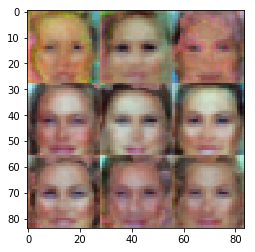

Epoch 1/1, step 2710... Discriminator Loss: 1.3223... Generator Loss: 0.7191... Total: 2.0414
Epoch 1/1, step 2720... Discriminator Loss: 1.8117... Generator Loss: 0.3998... Total: 2.2115
Epoch 1/1, step 2730... Discriminator Loss: 1.5811... Generator Loss: 0.7858... Total: 2.3669
Epoch 1/1, step 2740... Discriminator Loss: 1.4614... Generator Loss: 1.0086... Total: 2.4701
Epoch 1/1, step 2750... Discriminator Loss: 1.6360... Generator Loss: 0.5831... Total: 2.2191
Epoch 1/1, step 2760... Discriminator Loss: 1.4835... Generator Loss: 0.8383... Total: 2.3218
Epoch 1/1, step 2770... Discriminator Loss: 1.2357... Generator Loss: 2.0535... Total: 3.2892
Epoch 1/1, step 2780... Discriminator Loss: 1.3172... Generator Loss: 1.2165... Total: 2.5337
Epoch 1/1, step 2790... Discriminator Loss: 1.0576... Generator Loss: 0.9123... Total: 1.9699
Epoch 1/1, step 2800... Discriminator Loss: 0.9822... Generator Loss: 1.3900... Total: 2.3722


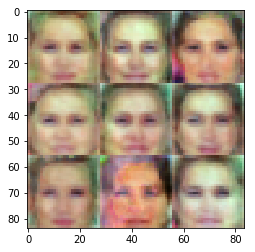

Epoch 1/1, step 2810... Discriminator Loss: 1.2863... Generator Loss: 0.8550... Total: 2.1413
Epoch 1/1, step 2820... Discriminator Loss: 1.1849... Generator Loss: 1.6979... Total: 2.8828
Epoch 1/1, step 2830... Discriminator Loss: 1.4891... Generator Loss: 0.7468... Total: 2.2359
Epoch 1/1, step 2840... Discriminator Loss: 1.5337... Generator Loss: 0.8568... Total: 2.3905
Epoch 1/1, step 2850... Discriminator Loss: 0.9749... Generator Loss: 1.2064... Total: 2.1814
Epoch 1/1, step 2860... Discriminator Loss: 0.9162... Generator Loss: 1.2362... Total: 2.1524
Epoch 1/1, step 2870... Discriminator Loss: 1.4016... Generator Loss: 2.0098... Total: 3.4113
Epoch 1/1, step 2880... Discriminator Loss: 1.5379... Generator Loss: 0.7468... Total: 2.2847
Epoch 1/1, step 2890... Discriminator Loss: 1.1967... Generator Loss: 0.8261... Total: 2.0229
Epoch 1/1, step 2900... Discriminator Loss: 1.0572... Generator Loss: 0.8777... Total: 1.9348


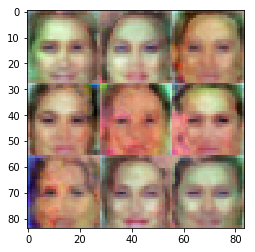

Epoch 1/1, step 2910... Discriminator Loss: 1.2062... Generator Loss: 1.0528... Total: 2.2591
Epoch 1/1, step 2920... Discriminator Loss: 1.0854... Generator Loss: 0.9172... Total: 2.0026
Epoch 1/1, step 2930... Discriminator Loss: 1.1863... Generator Loss: 0.9414... Total: 2.1278
Epoch 1/1, step 2940... Discriminator Loss: 1.7659... Generator Loss: 0.3273... Total: 2.0931
Epoch 1/1, step 2950... Discriminator Loss: 1.0642... Generator Loss: 0.9444... Total: 2.0086
Epoch 1/1, step 2960... Discriminator Loss: 1.0771... Generator Loss: 2.6438... Total: 3.7209
Epoch 1/1, step 2970... Discriminator Loss: 1.1723... Generator Loss: 0.8840... Total: 2.0563
Epoch 1/1, step 2980... Discriminator Loss: 1.3489... Generator Loss: 1.0926... Total: 2.4415
Epoch 1/1, step 2990... Discriminator Loss: 1.3858... Generator Loss: 0.6071... Total: 1.9928
Epoch 1/1, step 3000... Discriminator Loss: 1.7330... Generator Loss: 0.3951... Total: 2.1280


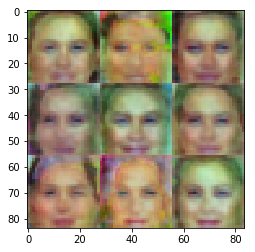

Epoch 1/1, step 3010... Discriminator Loss: 1.2275... Generator Loss: 0.6768... Total: 1.9043
Epoch 1/1, step 3020... Discriminator Loss: 1.1779... Generator Loss: 0.9057... Total: 2.0836
Epoch 1/1, step 3030... Discriminator Loss: 1.4795... Generator Loss: 0.9338... Total: 2.4133
Epoch 1/1, step 3040... Discriminator Loss: 1.3686... Generator Loss: 0.9737... Total: 2.3422
Epoch 1/1, step 3050... Discriminator Loss: 1.3140... Generator Loss: 1.1235... Total: 2.4375
Epoch 1/1, step 3060... Discriminator Loss: 1.2353... Generator Loss: 0.6237... Total: 1.8589
Epoch 1/1, step 3070... Discriminator Loss: 1.2172... Generator Loss: 0.6487... Total: 1.8659
Epoch 1/1, step 3080... Discriminator Loss: 0.6418... Generator Loss: 1.8228... Total: 2.4646
Epoch 1/1, step 3090... Discriminator Loss: 1.9348... Generator Loss: 0.3690... Total: 2.3038
Epoch 1/1, step 3100... Discriminator Loss: 1.4146... Generator Loss: 0.5856... Total: 2.0002


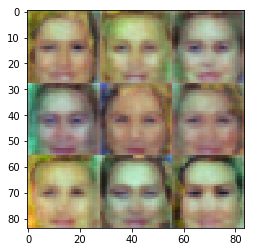

Epoch 1/1, step 3110... Discriminator Loss: 1.8429... Generator Loss: 0.4800... Total: 2.3229
Epoch 1/1, step 3120... Discriminator Loss: 0.9596... Generator Loss: 0.9117... Total: 1.8712
Epoch 1/1, step 3130... Discriminator Loss: 1.3136... Generator Loss: 1.0117... Total: 2.3253
Epoch 1/1, step 3140... Discriminator Loss: 1.2029... Generator Loss: 2.2057... Total: 3.4086
Epoch 1/1, step 3150... Discriminator Loss: 1.1600... Generator Loss: 0.8502... Total: 2.0102
Epoch 1/1, step 3160... Discriminator Loss: 1.2172... Generator Loss: 0.6380... Total: 1.8552


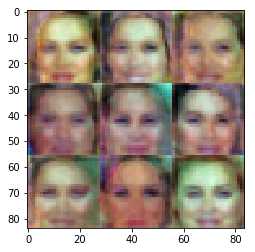

In [292]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

### Post Scriptum

I should have probably stopped way earlier. But if the judging criteria is that these look like faces, my phone agrees :)

![recognition](./recognition.jpg)

Also, I really regret not properly screenshotting the following image. This was when I used deconv instead of upsampling:

![ghost](./ghost.jpg)